The first notebook has a bit too much going on and not enough commentary, let's clean it up and start working from there :)

In [126]:
%matplotlib inline
import matplotlib.pyplot as plt
import pydicom
from fastai2.vision.all import *
from nbdev.showdoc import *
from fastai2.medical.imaging import *
import imageio
import seaborn as sns
from IPython.display import Image
from skimage import measure
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as FF
from plotly.graph_objs import *
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

First lets set up for file management variables and some easier paths to be accessing from.

The dicoms for training and testing are broken up into folders -- each has it's own csv as well

In [2]:
path = Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic')
path.ls()

(#6) [Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/test.csv'),Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/train'),Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/train.csv'),Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/test'),Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/osic-pulmonary-fibrosis-progression.zip'),Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/sample_submission.csv')]

In [3]:
Path.BASE_PATH = path
path.ls()

(#6) [Path('test.csv'),Path('train'),Path('train.csv'),Path('test'),Path('osic-pulmonary-fibrosis-progression.zip'),Path('sample_submission.csv')]

In [4]:
train_path = path/'train'
test_path = path/'test'
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
sample_sub = pd.read_csv(path/'sample_submission.csv')

In [5]:
train_df.shape, test_df.shape, sample_sub.shape

((1549, 7), (5, 7), (730, 3))

Hmm interesting - only 5 rows in the test csv but 730 required in submission file(!) - the number of patients in test matches the test df. For train, you see 176 patients but 1,549 measurements.

In [6]:
len(train_path.ls()), len(test_path.ls())

(176, 5)

Quickly examine the heads of all the csvs

In [7]:
#some nice tabular data to add to dicom info
train_df.head(1)

Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker

In [8]:
#same info as train
test_df.head(1)

Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00419637202311204720264      6  3020  70.186855   73  Male     Ex-smoker

In [9]:
#we need to predict FCV and the confidence for a particular wk
sample_sub.head(1)

Patient_Week   FVC  Confidence
0  ID00419637202311204720264_-12  2000         100

As mentioned, there are 176 patients but 1,549 measurements in the training csv -- what's up with that? Is there a gross distribution that we'll need to be mindful of? Meaning, do a few patients have 100's of measurements while the remaining only have 1 or 2?

In [10]:
train_df['Patient'].value_counts()

ID00229637202260254240583    10
ID00099637202206203080121    10
ID00167637202237397919352    10
ID00400637202305055099402    10
ID00421637202311550012437    10
                             ..
ID00381637202299644114027     7
ID00276637202271694539978     7
ID00186637202242472088675     7
ID00047637202184938901501     6
ID00267637202270790561585     6
Name: Patient, Length: 176, dtype: int64

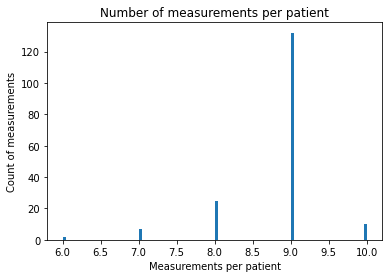

In [11]:
#ok so not too bad - most patients have 9 measurements
plt.hist(train_df['Patient'].value_counts(), bins=100)
plt.title('Number of measurements per patient')
plt.xlabel('Measurements per patient')
plt.ylabel('Count of measurements');

We know from the competition description that we'll need to be providing FVC/confidence values for multiple measurements (different time points). Be mindful of the fact that some of the week information in train_df doens't make sense (which seems to have been done intentionally)

In [12]:
train_df['Weeks'].value_counts()

 8     45
 12    44
 18    42
 10    41
 6     40
       ..
 95     1
 93     1
 91     1
 88     1
-2      1
Name: Weeks, Length: 112, dtype: int64

In [13]:
min(train_df['Weeks'])

-5

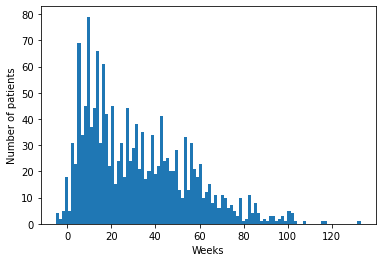

In [14]:
plt.hist(train_df['Weeks'], bins=100)
plt.xlabel('Weeks')
plt.ylabel('Number of patients');

Ok so some patients are measured over 40 weeks out - but also there are some patients with negative week values(!) The line below will show the proportion of this. This is mentioned in the competition description

In [15]:
(train_df['Weeks'] < 0).value_counts()

False    1538
True       11
Name: Weeks, dtype: int64

In [16]:
#let's index into the df to see just those with negatives
train_df[train_df['Weeks'] < 0]

Patient  Weeks   FVC     Percent  Age     Sex  \
0     ID00007637202177411956430     -4  2315   58.253649   79    Male   
80    ID00023637202179104603099     -3  1536   65.306122   71  Female   
175   ID00051637202185848464638     -1  1697   81.645417   73  Female   
261   ID00076637202199015035026     -4  2298   52.749977   51    Male   
297   ID00086637202203494931510     -5  3367  117.628563   65  Female   
323   ID00093637202205278167493     -1  3695   84.958153   69    Male   
438   ID00122637202216437668965     -4  2581   69.501293   58    Male   
534   ID00133637202223847701934     -2  3195   92.856312   83    Male   
840   ID00222637202259066229764     -1  2644   62.832700   70    Male   
894   ID00233637202260580149633     -3  3829  100.784376   68    Male   
1230  ID00340637202287399835821     -1  2345   59.038268   68    Male   

     SmokingStatus  
0        Ex-smoker  
80       Ex-smoker  
175      Ex-smoker  
261   Never smoked  
297   Never smoked  
323      Ex-smoker  
438      Ex-smoker  
534   Never smoked  
840      Ex-smoker  
894      Ex-smoker  
1230     Ex-smoker

Ok so no patient looks to have multiple negative measurements

Does each patient have the same number of dicoms? This can be simply gleaned from taking the number of dcms per folder.

We'll use a list comprehension to walk down the training path and examine the number of dcms per patient -- storing that value into the counts list. Fast.Ai's awesome convenience fxns that sit on top of normal python Pathlib fxns make this extraction possible with just that one line of code!

In [17]:
counts = [len(patients.ls()) for patients in train_path.ls() ]
len(counts), min(counts), max(counts) #1018? yikes

(176, 12, 1018)

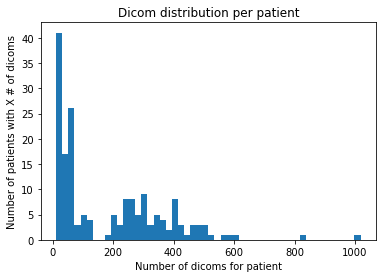

In [18]:
#most patients in the lower end of this
#some with multiple hundred???
plt.hist(counts, bins=50);
plt.xlabel('Number of dicoms for patient')
plt.ylabel('Number of patients with X # of dicoms')
plt.title('Dicom distribution per patient');

We'll be using a rescale slope/intercept later on to try to turn the scans into a more tenable format for our models. But  some scans have hundreds of slices while others only have a few -- the pixel spacing & slice thickness values vary between scanner, but this magnatude of difference in number of slices is also probably attributable to the fact that some scans take into account a larger area

Before diving into the dicoms - let's quickly try to glean some more info from the dfs

In [19]:
fem = (train_df['Sex'] == 'Female').sum()
male = len(train_df) - fem
print("There are {} females and {} males".format(fem, male))

There are 325 females and 1224 males


In [20]:
#ok so pretty big skew towards males
percent_female = fem/len(train_df) * 100
print(f"Only {percent_female:.2f}% of the dataset is female!!")

Only 20.98% of the dataset is female!!


Is this skew bc the disease is more prevalent for Men or because the sampling is skewed?

In [22]:
train_df['SmokingStatus'].value_counts()

Ex-smoker           1038
Never smoked         429
Currently smokes      82
Name: SmokingStatus, dtype: int64

In [23]:
ex_smoker = train_df['SmokingStatus'].value_counts()['Ex-smoker']
ex_smoker_perc = ex_smoker/len(train_df) * 100
smoker = train_df['SmokingStatus'].value_counts()['Currently smokes']
smoker_perc = smoker / len(train_df)*100
never_smoke = train_df['SmokingStatus'].value_counts()['Never smoked']
never_smoke_perc = never_smoke / len(train_df)*100

In [24]:
print(f'{ex_smoker_perc:.2f}% of measurements are of ex-smokers')
print(f'{smoker_perc:.2f}% of measurements are of current smokers')
print(f'{never_smoke_perc:.2f}% of measurements are of those who never smoked')

67.01% of measurements are of ex-smokers
5.29% of measurements are of current smokers
27.70% of measurements are of those who never smoked


~72 of the FVC measurements are of people who previously smoked or currently do

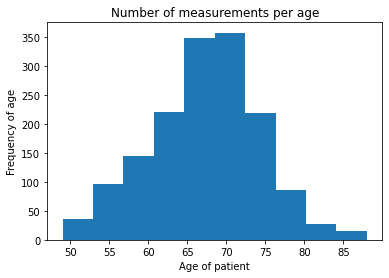

In [25]:
plt.hist(train_df['Age'])
plt.xlabel("Age of patient")
plt.ylabel("Frequency of age")
plt.title('Number of measurements per age');

FVC check

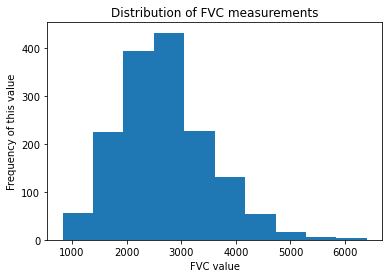

In [26]:
plt.hist(train_df['FVC'])
plt.xlabel('FVC value')
plt.ylabel('Frequency of this value')
plt.title('Distribution of FVC measurements');

There is most certainly some statistical correlation between the age of the patient, their gender and smoking status in relation to the FVC measurements. At this point we could determine that relationship and then try to develop a model based on these meta features.

But that's probably already been exhaustively explored, why else are we going through the effort of trying to develop a solution through the use of imaging?

Should circle back around and create some visualization that would elucidate this later -- really just itching to dive into the dicoms right now though. 

While the best solution will most likely create a vision model and then feed the output of that into a normal fully connected network that takes into account this metadata from the csv -- that's for another day!

In [58]:
#choosing two patients (second one chosen intentionally)
patient_1 = train_path.ls()[100]
patient_2 = (train_path/'ID00232637202260377586117')
len(patient_1.ls()), len(patient_2.ls())

(36, 67)

In [59]:
patient_1_slice = patient_1.ls()[0]
patient_2_slice = patient_2.ls()[0]
patient_1_slice, patient_2_slice

(Path('train/ID00408637202308839708961/18.dcm'),
 Path('train/ID00232637202260377586117/18.dcm'))

In [60]:
dcmread(patient_1_slice)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.158180224579486107106172137277788130663
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0018) SOP Instance UID                    UI: 2.25.158180224579486107106172137277788130663
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) Manufacturer                        LO: 'SIEMENS'

A whole lot of info in one file! 

The following resource helps interpret some of it: http://dicom.nema.org/medical/dicom/2017d/output/chtml/part03/sect_C.7.6.2.html

(0020, 0013) Instance Number --> IS: "18"
Corresponds to the fact that this is the 18th dicom for this patient (are they ordered in a spatial way?)

These two determine **voxel size**:


**(0018, 0050) Slice Thickness --> DS: "5.0"
this is expressed in millimeters** --> z-axis

**(0028, 0030) Pixel Spacing --> DS: [0.683, 0.683]
physical distance between center of each pixel. The pair of values indicates adjacent row spacing and adjacent column spacing** --> x/y plane

(0020, 1041) Slice Location --> DS: "82.0"
relative position of the image plane expressed in millimeters

(0020, 0032) Image Position (Patient) --> DS: [-174.2187, -175.0000, 1773.500] tells the x,y,z coordinates of the upper left hand corner (center of the firxt voxel transmitted) of image in millimeters

We will also take into account the Rescale slope & intercept below in order to convert the pixel values into the Hounsfield scale: https://en.wikipedia.org/wiki/Hounsfield_scale

In [61]:
dcmread(patient_1_slice).PixelData[0:20]

b'H\x00\x1d\x00\x15\x00\x00\x000\x00\x00\x00\x0e\x00*\x00\x1c\x00,\x00'

The pixel information is stored in hex -- we could try to do the conversion ourselves but that sounds cumbersome. Luckily we can just access the information with "pixel_array"

In [62]:
pat_1_dcm = dcmread(patient_1_slice)
pat_1_dcm.pixel_array

array([[72, 29, 21, ...,  0,  0,  0],
       [ 0, 14, 25, ...,  0,  0,  0],
       [27,  0, 21, ...,  0,  0,  0],
       ...,
       [ 0, 74,  0, ...,  0,  0,  0],
       [ 0, 77, 24, ...,  0,  0,  0],
       [23,  0,  8, ...,  0,  0,  0]], dtype=uint16)

A quick but important digression, if you look at some of the pixel information for certain patients (like the second one chosen) you'll see some funky values initially (this was done in the previous notebook) 

All those initial values of -2048(!) This will be further explored during our conversion to the hounsfield scale

In [63]:
pat_2_dcm = dcmread(patient_2_slice)
pat_2_dcm.pixel_array

array([[-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       ...,
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048]], dtype=int16)

In [64]:
#ok so 512 by 512 pixel slices
pat_1_dcm.pixel_array.shape, pat_2_dcm.pixel_array.shape

((512, 512), (512, 512))

We'll take a look at the patients FVC measurements as well and see if we can glean anything from this ONE slice of the CT scan

In [65]:
train_df[train_df['Patient'] == patient_1.name]

Patient  Weeks   FVC    Percent  Age   Sex  \
1469  ID00408637202308839708961     13  2651  97.405938   74  Male   
1470  ID00408637202308839708961     14  2377  87.338330   74  Male   
1471  ID00408637202308839708961     16  2414  88.697825   74  Male   
1472  ID00408637202308839708961     18  2384  87.595532   74  Male   
1473  ID00408637202308839708961     20  2181  80.136684   74  Male   
1474  ID00408637202308839708961     26  2374  87.228101   74  Male   
1475  ID00408637202308839708961     37  2504  92.004703   74  Male   
1476  ID00408637202308839708961     50  2416  88.771311   74  Male   

     SmokingStatus  
1469     Ex-smoker  
1470     Ex-smoker  
1471     Ex-smoker  
1472     Ex-smoker  
1473     Ex-smoker  
1474     Ex-smoker  
1475     Ex-smoker  
1476     Ex-smoker

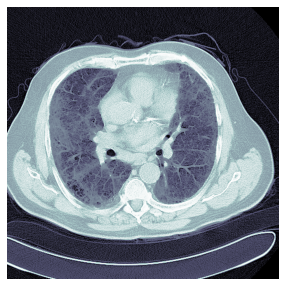

In [66]:
pat_1_dcm.show()

In [67]:
train_df[train_df['Patient'] == patient_2.name]

Patient  Weeks   FVC     Percent  Age     Sex  \
885  ID00232637202260377586117      9  1909  115.431128   74  Female   
886  ID00232637202260377586117     11  1977  119.542871   74  Female   
887  ID00232637202260377586117     13  2095  126.677954   74  Female   
888  ID00232637202260377586117     15  1841  111.319386   74  Female   
889  ID00232637202260377586117     17  1803  109.021647   74  Female   
890  ID00232637202260377586117     23  1732  104.728504   74  Female   
891  ID00232637202260377586117     35  2095  126.677954   74  Female   
892  ID00232637202260377586117     47  1813  109.626315   74  Female   
893  ID00232637202260377586117     63  1845  111.561253   74  Female   

    SmokingStatus  
885  Never smoked  
886  Never smoked  
887  Never smoked  
888  Never smoked  
889  Never smoked  
890  Never smoked  
891  Never smoked  
892  Never smoked  
893  Never smoked

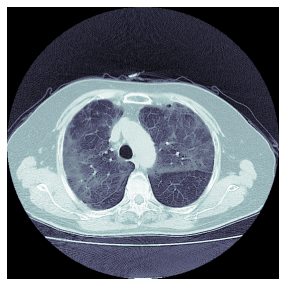

In [68]:
pat_2_dcm.show()

Fastai's show method makes it easy to view a dicom :)

Considering these two patients FVC and metadata informaion. Both are the same age, but the first is a male and was a smoker

The percent field indicates: "a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics"

So while patient #2 has a smaller FVC - she is crushing the rest of her peers with similar characteristics. The lower FVC can be explained by a discrepency of size. A male that is 6" taller than a female will most likely have a bigger lung capacity. In terms of how the scans look, patient #2's scan is making me less uncomfortable bc it doesn't have that huge mass in the middle

Did you notice another difference between the two scans??

Aside from the fact that both lungs really different(!) you can also see a very clear circular boundary around the second scan(!) This explains those -2000 values when we saw the pixel array. What gives?

If you reference the hounsfield scale (https://en.wikipedia.org/wiki/Hounsfield_scale) you'll notice that the air only goes to -1000. As explained by Dr. Chen: these low values represent the voxels that are outside of the bore of the CT. An issue of this is that bc Air has a higher value - it appears grey (as opposed to being black) and this reduces the contrast of the lungs and soft tissue that we hope to examine! 

https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/

^Alot of the visualizations that we'll explore are from Dr. Chens amazing tutorial! Since it is over 3 years old, we'll have to modify some things. Another great refernece notebook that many people in this competition are using is that of Guido Zuidhof (https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial). We'll come to his work for the segmentation portion however

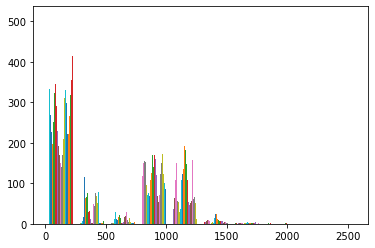

In [69]:
plt.hist(pat_1_dcm.pixel_array);

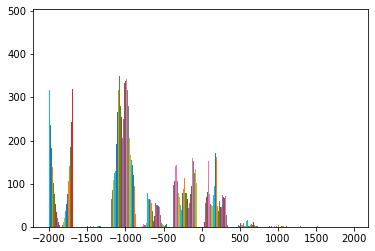

In [70]:
plt.hist(pat_2_dcm.pixel_array);

So we can see that the slice with the border (patient #2) has a differnt pixel distribution! We will work on rectifying this in a bit through resampling! 

Before we get to that, let's take a peek at the metadata distribution across patients and see if anything striking comes to the fore -- we'll make the assumption that for each patient, one scan will have the same information as all the other scans in that folder. The discrepency should not be seen inside a specific scan of a patient but between different patients!

In [71]:
#can access item in a dicom with:
PS = dcmread(patient_1.ls()[0]).PixelSpacing
PS, type(PS)

([0.724609375, 0.724609375], pydicom.multival.MultiValue)

This has a (weird) type associated with dicoms -- this is something to be mindful of when resampling. Converting between types could lead to information loss or distortion which could explain why I had so much trouble with the segmentation visualizations in the first pass

Each scan has it's own slice thickness & pixel spacing, which helps explain the discrepency in the number of dicoms per patient

In [72]:
slice_thick = []
pixel_spacing = []
rescale_slope = []
rescale_intercept = []
rows, columns = [], []

This will walk down all the folders, each which has it's own scan, it will pull the first slice in each folder and then extract the values for all items initialized above (we know that the x & y items in PixelSpacing are the same for all scans, so I won't create a fxn to check that)

In [73]:
for x in train_path.ls():
    dcm = dcmread(x.ls()[0]) #dcm of one slice
    pixel_spacing.append(float(dcm.PixelSpacing[0]))
    slice_thick.append(float(dcm.SliceThickness))
    rescale_intercept.append(float(dcm.RescaleIntercept))
    rescale_slope.append(float(dcm.RescaleSlope))
    rows.append(float(dcm.Rows))
    columns.append(float(dcm.Columns))

In [110]:
patient_id = [x.name for x in train_path.ls()]
scan_values = pd.DataFrame(data=patient_id, columns=['patient'])
scan_values['slice_thickness'] = slice_thick
scan_values['pixel_spacing'] = pixel_spacing
scan_values['n_rows'] = rows
scan_values['n_columns'] = columns
scan_values['rescale_intercept'] = rescale_intercept
scan_values['rescale_slope'] = rescale_slope

In [111]:
#this will let us identify which scans to look @ for topics
scan_values

patient  slice_thickness  pixel_spacing  n_rows  \
0    ID00232637202260377586117            5.000       0.683000   512.0   
1    ID00134637202223873059688            1.000       0.740234   512.0   
2    ID00093637202205278167493            1.000       0.880859   512.0   
3    ID00307637202282126172865            1.000       0.707031   512.0   
4    ID00364637202296074419422            1.000       0.712891   512.0   
..                         ...              ...            ...     ...   
171  ID00336637202286801879145            1.000       0.650391   512.0   
172  ID00383637202300493233675            1.000       0.656250   512.0   
173  ID00067637202189903532242            1.250       0.871094   733.0   
174  ID00317637202283194142136            0.625       0.677734   512.0   
175  ID00104637202208063407045            0.500       0.665000   512.0   

     n_columns  rescale_intercept  rescale_slope  
0        512.0                0.0            1.0  
1        512.0            -1024.0            1.0  
2        512.0            -1024.0            1.0  
3        512.0            -1024.0            1.0  
4        512.0            -1024.0            1.0  
..         ...                ...            ...  
171      512.0            -1024.0            1.0  
172      512.0            -1024.0            1.0  
173      888.0                0.0            1.0  
174      512.0            -1024.0            1.0  
175      512.0                0.0            1.0  

[176 rows x 7 columns]

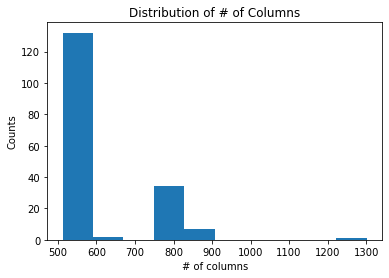

In [112]:
plt.title('Distribution of # of Columns')
plt.xlabel('# of columns')
plt.ylabel('Counts')
plt.hist(columns);

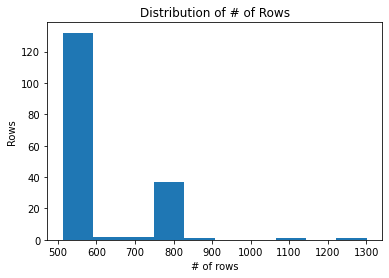

In [113]:
plt.title('Distribution of # of Rows')
plt.xlabel('# of rows')
plt.ylabel('Rows')
plt.hist(rows);

Ok so some images are clearly NOT 512x512

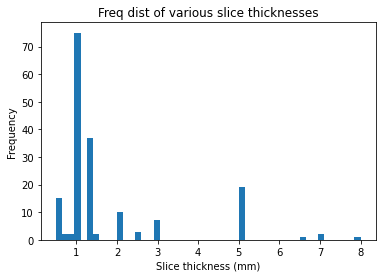

In [114]:
plt.xlabel('Slice thickness (mm)')
plt.ylabel('Frequency')
plt.title('Freq dist of various slice thicknesses')
plt.hist(slice_thick, bins=50);

In [115]:
max(slice_thick), min(slice_thick)

(8.0, 0.5)

Oh.... Some slices are 16+ times thicker than others.

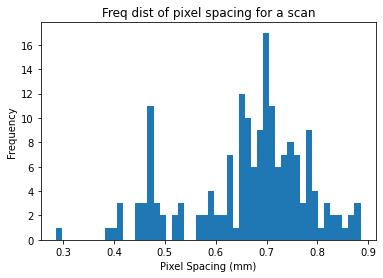

In [116]:
plt.xlabel('Pixel Spacing (mm)')
plt.ylabel('Frequency')
plt.title('Freq dist of pixel spacing for a scan')
plt.hist(pixel_spacing, bins=50);

In [117]:
#ok a 4 fold increase between smallest and biggest
min(pixel_spacing), max(pixel_spacing)

(0.286313, 0.884766)

Let's look at the area & volume that

In [118]:
#can index in pandas quite conveniently :)
scan_values.pixel_spacing

0      0.683000
1      0.740234
2      0.880859
3      0.707031
4      0.712891
         ...   
171    0.650391
172    0.656250
173    0.871094
174    0.677734
175    0.665000
Name: pixel_spacing, Length: 176, dtype: float64

In [133]:
#we know pixel_spacing same in both dimensions
scan_values['row_distance'] = scan_values.n_rows * scan_values.pixel_spacing
scan_values['column_distance'] = scan_values.n_columns * scan_values.pixel_spacing
#now we can compute the area (mm2) and volume (mm3)
scan_values['area'] = (scan_values.row_distance * scan_values.column_distance)*0.1
#slice thickness is the depth dimension
scan_values['volume'] = (scan_values.slice_thickness * scan_values.area)*0.1

Text(0.5, 1.0, 'Distribution of scan slice volume (cm**3)')

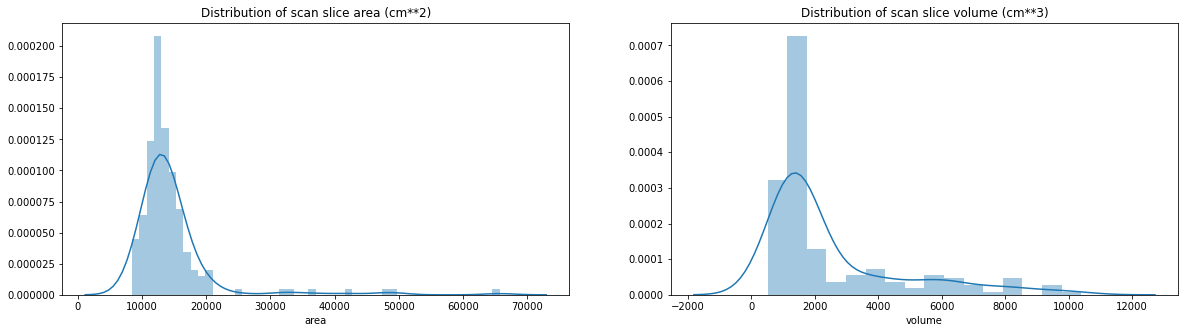

In [137]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(scan_values.area, ax=ax[0])
sns.distplot(scan_values.volume, ax=ax[1])
ax[0].set_title('Distribution of scan slice area (cm**2)')
ax[1].set_title('Distribution of scan slice volume (cm**3)')

Ok we can see that some images have a way bigger area/volume (voxel size) than others

Let's also look at the rescale slope & intercept

In [84]:
#Cast to pandas object and then confirm slope is same for all
pd.Series(rescale_slope).value_counts()

1.0    176
dtype: int64

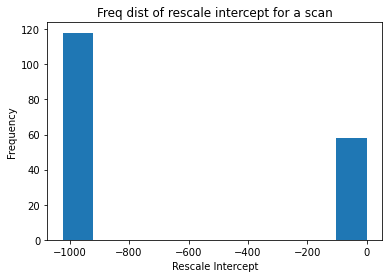

In [85]:
plt.xlabel('Rescale Intercept')
plt.ylabel('Frequency')
plt.title('Freq dist of rescale intercept for a scan')
plt.hist(rescale_intercept);

In [86]:
pd.Series(rescale_intercept).value_counts()

-1024.0    117
 0.0        58
-1000.0      1
dtype: int64

This rescale intercept will play a role in our conversion to the hounsfield scale. Since all the slopes are 1, we don't really need to do anything with that. We presumably can skip that computation or at the very least skip the lookup into a dicom to retrieve that value

Enough EDA for the time being. Let's direct our attenton towards  the elephant in the room -- the images themselves.

We don't want to keep referencing the dicoms in memory in order to visualize, transform and revisualize. So let's create a function that will extract the dicoms (in the correct order)  so that we can stack them into an array for the patient. This array will preserve the information of the dicom initially but we'll mainly want to pull out the pixel information which we can then keep in a numpy array or pytorch tensor

We will also use this later on when we try to process the entire dataset and then save for use in our modeling!

In [50]:
patient_1.ls()[0].name, dcmread(patient_1.ls()[0]).InstanceNumber

('18.dcm', "18")

The above just shows that the title of dicom file corresponds to the instance number inside the dicom. The instance number helps orient the order we want to visualize, process and interpret the scans

In [51]:
def dcm_sort(patient_folder):
    #list comprehension that runs through folder of dicoms
    dcm_stacked = [dcmread(dcm) for dcm in patient_folder.ls()]
    dcm_stacked.sort(key=lambda x: int(x.InstanceNumber))
    #returning a python list of dicoms sorted
    return dcm_stacked

Tried use dcm_stacked in above fxn for the return by doing the sort in the return fxn - it did not work for some reason. And it must be done before the return
I guess that makes sense - sorting is somewhat memory intensive and it's not like you're just doing a simple computation on a return value (or set of return values)

In [52]:
#to confirm that output in ascending order
sortz = dcm_sort(patient_1)
sortz[0].InstanceNumber, sortz[1].InstanceNumber, sortz[35].InstanceNumber

("1", "2", "36")

In [53]:
type(sortz)

list

In [54]:
#patient 1 didn't have the border so let's progress with #2
sorted_dcm = dcm_sort(patient_2)
len(sorted_dcm)

67

In [55]:
#Just to show all the black pixels on the borders
sorted_dcm[0].pixel_array

array([[-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       ...,
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048]], dtype=int16)

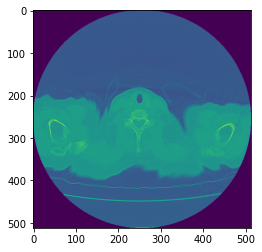

In [56]:
plt.imshow(sorted_dcm[0].pixel_array);

That doesn't look like a lung as we were hoping for. Why? Presumably because as you approach the top and bottom of the scan, you are no longer looking at the lung cavity itself but perhaps the boundary point or beyond. Let's take a look at a scan in the middle!

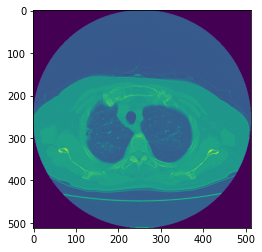

In [57]:
one_slice = sorted_dcm[12].pixel_array
plt.imshow(one_slice); #much better!

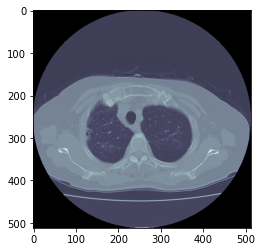

In [58]:
#try out different color maps -- bone seems to be standard
#color map is not changing the underlying pixel information
#plt.imshow(one_slice, cmap='spring');
plt.imshow(one_slice, cmap='bone');

In [59]:
pd.Series(one_slice.flatten()).value_counts()[0:10]

-2048    56252
-1007      721
-1024      716
-1011      704
-1009      703
-1022      702
-1019      691
-999       688
-1008      683
-995       679
dtype: int64

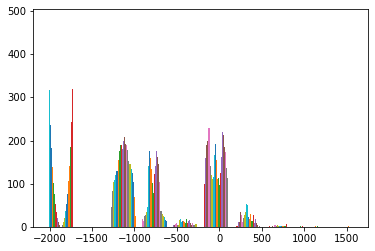

In [60]:
#Let's take a look at a histogram for this patient
plt.hist(one_slice);

Example below shows cool indexing to manipulate pixels on the whole if they meet some condition

In [61]:
small = one_slice[0:3, 0:3]
small

array([[-2048, -2048, -2048],
       [-2048, -2048, -2048],
       [-2048, -2048, -2048]], dtype=int16)

In [62]:
small[small <= -1000] = 0
small

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=int16)

Using that - let's create a function that lets you choose a threshold value and then replace all the pixels that are at or below said value. 

-1000 represents air in the hounsfield scale and 0 represents water

Rather than doing it on a single slice, let's operate over all of the slices for a patient at once

In [63]:
def ct_transformed_hu(dcm_sorted, threshold=-2000, replace=-1000):
    intercept = dcm_sorted[0].RescaleIntercept
    slices_stacked = np.stack([dcm.pixel_array for dcm in dcm_sorted])
    slices_stacked = slices_stacked.astype(float)
    
    #converts the unknown values to desired replacement
    slices_stacked[slices_stacked <= threshold] = replace
    
    #turn into hounsfield scale
    slices_stacked += np.int16(intercept)
    
    return np.array(slices_stacked, dtype=np.int16)

In [64]:
hu_ct = ct_transformed_hu(sorted_dcm, replace=0)

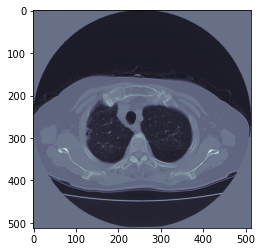

In [65]:
#that's not what we wanted..... the border is just grey now
plt.imshow(hu_ct[12], cmap='bone');

In [66]:
#this is bc the rescale intercept is zero for this scan
#chose -1000 for the replace value-- want it to look like air
hu_ct = ct_transformed_hu(sorted_dcm, threshold=-2000, 
                         replace=-1000)

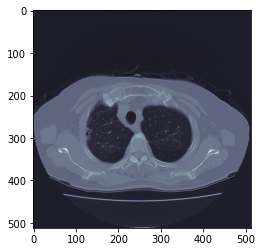

In [67]:
#nice! now the border is gone
plt.imshow(hu_ct[12], cmap='bone');

Alot of people are saving the gif till the end -- let's check it out right now and see if things look different once we've resampled

In [68]:
def set_lungwin(img, hu=[-1200., 600.]):
    lungwin = np.array(hu)
    newimg = (img-lungwin[0]) / (lungwin[1]-lungwin[0])
    newimg[newimg < 0] = 0
    newimg[newimg > 1] = 1
    newimg = (newimg * 255).astype('uint8')
    return newimg

In [72]:
hu_array = set_lungwin(hu_ct)

In [73]:
imageio.mimsave("/tmp/gif.gif", hu_array, duration=0.0001)
Image(filename="/tmp/gif.gif", format='png')

ValueError: Invalid properties specified for object of type plotly.graph_objs.Image: ('filename', 'format')

    Valid properties:
        colormodel
            Color model used to map the numerical color components
            described in `z` into colors.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on Chart Studio Cloud for
            customdata .
        dx
            Set the pixel's horizontal size.
        dy
            Set the pixel's vertical size
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on Chart Studio Cloud for
            hoverinfo .
        hoverlabel
            :class:`plotly.graph_objects.image.Hoverlabel` instance
            or dict with compatible properties
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}". https://github.com/d3/d3-3.x-api-
            reference/blob/master/Formatting.md#d3_format for
            details on the formatting syntax. Dates are formatted
            using d3-time-format's syntax %{variable|d3-time-
            format}, for example "Day: %{2019-01-01|%A}".
            https://github.com/d3/d3-3.x-api-
            reference/blob/master/Time-Formatting.md#format for
            details on the date formatting syntax. The variables
            available in `hovertemplate` are the ones emitted as
            event data described at this link
            https://plotly.com/javascript/plotlyjs-events/#event-
            data. Additionally, every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available. variables `z`, `color` and `colormodel`.
            Anything contained in tag `<extra>` is displayed in the
            secondary box, for example
            "<extra>{fullData.name}</extra>". To hide the secondary
            box completely, use an empty tag `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on Chart Studio Cloud for
            hovertemplate .
        hovertext
            Same as `text`.
        hovertextsrc
            Sets the source reference on Chart Studio Cloud for
            hovertext .
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on Chart Studio Cloud for
            ids .
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            meta .
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        opacity
            Sets the opacity of the trace.
        stream
            :class:`plotly.graph_objects.image.Stream` instance or
            dict with compatible properties
        text
            Sets the text elements associated with each z value.
        textsrc
            Sets the source reference on Chart Studio Cloud for
            text .
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        x0
            Set the image's x position.
        xaxis
            Sets a reference between this trace's x coordinates and
            a 2D cartesian x axis. If "x" (the default value), the
            x coordinates refer to `layout.xaxis`. If "x2", the x
            coordinates refer to `layout.xaxis2`, and so on.
        y0
            Set the image's y position.
        yaxis
            Sets a reference between this trace's y coordinates and
            a 2D cartesian y axis. If "y" (the default value), the
            y coordinates refer to `layout.yaxis`. If "y2", the y
            coordinates refer to `layout.yaxis2`, and so on.
        z
            A 2-dimensional array in which each element is an array
            of 3 or 4 numbers representing a color.
        zmax
            Array defining the higher bound for each color
            component. Note that the default value will depend on
            the colormodel. For the `rgb` colormodel, it is [255,
            255, 255]. For the `rgba` colormodel, it is [255, 255,
            255, 1]. For the `hsl` colormodel, it is [360, 100,
            100]. For the `hsla` colormodel, it is [360, 100, 100,
            1].
        zmin
            Array defining the lower bound for each color
            component. Note that the default value will depend on
            the colormodel. For the `rgb` colormodel, it is [0, 0,
            0]. For the `rgba` colormodel, it is [0, 0, 0, 0]. For
            the `hsl` colormodel, it is [0, 0, 0]. For the `hsla`
            colormodel, it is [0, 0, 0, 0].
        zsrc
            Sets the source reference on Chart Studio Cloud for  z
            .
        

The resampling shown below is also from Dr. Chen

We want to utilize the slice thickness & pixel spacing information in order to resample each slice to 1x1x1mm pixels so we can be able to compare and display the scans in 3D 

In [ ]:
def resample(slices, dcms, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([dcms[0].SliceThickness] + [dcms[0].PixelSpacing[0],
                                                dcms[1].PixelSpacing[1]]))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = slices.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / slices.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(slices, real_resize_factor)
    
    return image, new_spacing

In [ ]:
resampled_img, new_spacing = resample(hu_array, sorted_dcm)

In [ ]:
print('Shape before resampling: ', hu_array.shape)
print('Shape after resampling: ', resampled_img.shape)

In [ ]:
new_spacing

For some reason the 3D viz with plotly renders better - so we'll look at that first

In [ ]:
def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface")
    p = image.transpose(2,1,0)
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes(p, 
                threshold, step_size=step_size, 
                method='lewiner', allow_degenerate=True) 
    return verts, faces

In [ ]:
??measure.marching_cubes

In [ ]:
def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

In [ ]:
#measure.marching_cubes(resampled_img.transpose(2,1,0), -300)

In [ ]:
hu_array.shape

In [ ]:
verts, faces = make_mesh(hu_ct, 450, 1.5)
plotly_3d(verts, faces)

In Dr. Chens tutorial he does this 3D viz with the resampled image -- but this keeps throwing an error. Had to use the original pixels converted to HU. It's crashing out during marching cubes fxn for some reason(!)

In [ ]:
def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces])
    mesh.set_edgecolor('b')
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    plt.show()

In [ ]:
verts, faces = make_mesh(hu_ct, 700, 1.5)
plt_3d(verts, faces)

This is def upside down and it looks like there's some weird plate behind the spine(?)